In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import pandas as pd
import scipy.stats as sps
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import math
from mlxtend.feature_selection import SequentialFeatureSelector 
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
##Generate training_testing & oot 
tt = pd.read_csv("training_testing.csv")
oot = pd.read_csv("out_of_time.csv")

In [3]:
variables = list(tt.columns)
for col in ['Unnamed: 0','record', 'date']:
    variables.remove(col)
len(variables)

288

## KS & FDR

In [4]:
#Build KS & FDR Dataframe 
KSFDR = pd.DataFrame({'var': range(0,288)})

i=0
for variable in variables :
    KSFDR['var'][i] = variables[i]
    i=i+1

KSFDR["ks"] = ""
KSFDR["FDR"] = ""

In [5]:
tt = tt.drop(columns = ['Unnamed: 0','record', 'date']).copy()

In [6]:
#Calculate KS

goods = tt[tt.fraud_label == 0]
bads = tt[tt.fraud_label == 1] 

i = 0
for column in tt:
    KSFDR['ks'][i] = sps.ks_2samp(goods[column],bads[column])[0]
    i = i+1

In [11]:
#Calculate FDR
topRows = int(round(len(tt)*0.03))

j = 0
for column in tt:
    temp1 = tt.sort_values(column,ascending=False).head(topRows)
    temp2 = tt.sort_values(column,ascending=True).head(topRows)
    needed1 = temp1.loc[:,'fraud_label']
    needed2 = temp2.loc[:,'fraud_label']
    FDR1 = sum(needed1)/len(bads)
    FDR2 = sum(needed2)/len(bads)
    FDRate = np.maximum(FDR1,FDR2)
    KSFDR.loc[j, 'FDR'] = FDRate
    j = j +1

In [12]:
KSFDR['rank_ks'] = KSFDR['ks'].rank(ascending = True)
KSFDR['rank_FDR'] = KSFDR['FDR'].rank(ascending = True)
KSFDR['average_rank'] = (KSFDR['rank_ks'] + KSFDR['rank_FDR']) / 2

In [14]:
KSFDR.sort_values(by=['average_rank'], ascending=False, inplace=True)

In [15]:
KSFDR.to_csv('KSFDR1.csv', index=False)

In [17]:
# spliting training and testing here 

from sklearn.model_selection import train_test_split
train, test = train_test_split(tt, test_size=0.2,random_state=42)

## Select top 50 variabels from KSFDR

In [18]:
#drop 2 variables and select 50 variables from KSFDR 
KSFDR.drop(KSFDR.loc[KSFDR['var']=='fraud_label'].index, inplace=True)
KSFDR.drop(KSFDR.loc[KSFDR['var']=='random'].index, inplace=True)

In [25]:
KSFDR.shape

(286, 6)

In [20]:
var_top50 = KSFDR.nlargest(50,['average_rank']).copy()
var_top50 = list(var_top50['var'])

In [26]:
print(var_top50)

['addr_lag30_count', 'address_lag30_count', 'addr_#days_since', 'address_#days_since', 'address_lag14_count', 'addr_lag14_count', 'address_lag7_count', 'addr_lag7_count', 'address_lag3_count', 'addr_lag3_count', 'address_lag1_count', 'addr_lag1_count', 'addr-homephone_lag30_count', 'ssn-dob_lag30_count', 'name-dob_lag30_count', 'ssn_lag30_count', 'ssn-name-dob_lag30_count', 'ssn-firstname_lag30_count', 'addr-homephone_#days_since', 'ssn-lastname_lag30_count', 'ssn-name_lag30_count', 'ssn-dob_#days_since', 'addr-homephone_lag14_count', 'name-dob_#days_since', 'ssn_#days_since', 'ssn-firstname_#days_since', 'ssn-name-dob_#days_since', 'ssn-lastname_#days_since', 'name-dob_lag14_count', 'ssn-name_#days_since', 'ssn-dob_lag14_count', 'ssn_lag14_count', 'name_lag30_count', 'ssn-name-dob_lag14_count', 'ssn-firstname_lag14_count', 'ssn-lastname_lag14_count', 'ssn-name_lag14_count', 'address_lag1_lag14_avg', 'addr_lag1_lag14_avg', 'addr-homephone_lag7_count', 'name-dob_lag7_count', 'ssn-dob_la

In [27]:
#build train_x and train_y
train_x = np.array(train[train.columns.intersection(var_top50)])
train_y = np.array(train['fraud_label'])

## RFECV 

In [29]:
#build a timer to track running time
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        tmin, tsec = divmod((datetime.now() - start_time).total_seconds(), 60)
        print('\n Time taken: %i minutes and %s seconds.' % (tmin, round(tsec, 2)))

In [30]:
#define model here and adjust parameters 
from sklearn.feature_selection import RFECV

model = LogisticRegression()
rfecv = RFECV(estimator=model, step=1, cv=2, verbose=3, n_jobs=-1, scoring='roc_auc')

In [32]:
#Run RFECV
#Estimate feature importance and time the whole process
starttime = timer(None)
start_time = timer(None)
rfecv.fit(train_x, train_y)
timer(start_time)


 Time taken: 9 minutes and 47.56 seconds.


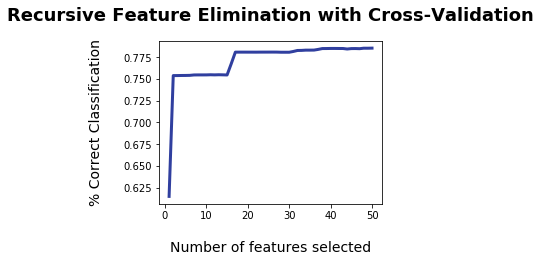

In [34]:
plt.figure(figsize=(4, 3))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [43]:
#convert features ranking to a dataframe 
dftrain_x_1 = train[train.columns.intersection(var_top50)]
features_rfecv = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfecv.ranking_), dftrain_x_1.columns)),
                            columns = ['ranking', 'variable'])

,ranking,variable
0,1,addr-homephone_#days_since
1,1,addr-homephone_lag14_count
2,1,addr-homephone_lag30_count
3,1,addr-homephone_lag7_count
4,1,addr_#days_since
5,1,addr_lag14_count
6,1,addr_lag1_count
7,1,addr_lag1_lag14_avg
8,1,addr_lag30_count
9,1,addr_lag3_count


In [42]:
#select top20 features according to the graph 
features_rfecv = features_rfecv.iloc[:20]
features_rfecv_50 = list(features_rfecv['variable'])
print(features_rfecv_50)

['addr-homephone_#days_since', 'addr-homephone_lag14_count', 'addr-homephone_lag30_count', 'addr-homephone_lag7_count', 'addr_#days_since', 'addr_lag14_count', 'addr_lag1_count', 'addr_lag1_lag14_avg', 'addr_lag30_count', 'addr_lag3_count', 'addr_lag7_count', 'address_#days_since', 'address_lag14_count', 'address_lag1_count', 'address_lag1_lag14_avg', 'address_lag30_count', 'address_lag3_count', 'address_lag7_count', 'homephone_lag7_count', 'name-dob_#days_since']


## Log Regression

In [60]:
#update train, test, oot dataset 
X_train = np.array(train[train.columns.intersection(features_rfecv_50)])
Y_train = np.array(train['fraud_label'])
X_test = np.array(test[test.columns.intersection(features_rfecv_50)])
Y_test = np.array(test['fraud_label'])
X_oot = np.array(oot[oot.columns.intersection(features_rfecv_50)])
Y_oot = np.array(oot['fraud_label'])

In [61]:
#log regression on train
logreg  = LogisticRegression(max_iter=5000)

logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [73]:
logit  = LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='saga', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [75]:
y_pred_tn = logreg.predict_proba(X_train)
print(y_pred_tn[:,1])

[0.00642363 0.00558408 0.0055982  ... 0.01330032 0.00725255 0.00823131]


In [76]:
#3% FDR for training 

#  calcuate number of records in a 3% bin
a = int(round(len(train)*0.03))

# count how many fraud records are there in the training data
total_fraud_train = len(train[train['fraud_label']==1])

train_1 = train.copy()
train_1['pred_score'] = y_pred_tn[:,1]

# sort training records according to pred_score, so we can get top 3%
train_1 = train_1.sort_values(by='pred_score', ascending = False)

# count in the top a records (3%) in the training data ranked by pred_score, 
# the proportion of fraud caught from all the fraud records in the training set
print("3% FDR for training is ", len(train_1[:a][train_1['fraud_label']==1])/total_fraud_train)


3% FDR for training is  0.4782373906469381


In [50]:
from sklearn.metrics import accuracy_score
log_socre = accuracy_score(Y_test, y_pred)
print('score for train by log model :',log_socre)

ValueError: Found input variables with inconsistent numbers of samples: [159000, 635996]

In [59]:

#  calcuate number of records in a 3% bin
a = int(round(len(train)*0.03))

# count how many fraud records are there in the training data
total_fraud_train = len(train[train['fraud_label']==1])

train_1 = train.copy()
train_1['pred_score'] = y_pred

# sort training records according to pred_score, so we can get top 3%
train_1 = train_1.sort_values(by='pred_score', ascending = False)

# count in the top a records (3%) in the training data ranked by pred_score, 
# the proportion of fraud caught from all the fraud records in the training set
print("3% FDR for training is ", len(train_1[:a][train_1['fraud_label']==1])/total_fraud_train)


3% FDR for training is  0.2925801922453829
